# 0. Import Dependencies

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable 

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdate

from alpha_vantage.timeseries import TimeSeries 

from neuralprophet import NeuralProphet
import pandas as pd
import datetime as dt
import requests

from sklearn.metrics import mean_squared_error, mean_absolute_error

print("All libraries loaded")

All libraries loaded


# 1. Set Data Configuration

In [2]:
config = {
    "alpha_vantage": {
        "key": "0FZBV3K8TP7HOLZM", # Claim your free API key here: https://www.alphavantage.co/support/#api-key
        "symbol": "FTXN", # First Trust Nasdaq Oil & Gas ETF
        "outputsize": "full",
        "key_close": "4. close", # changed
    },
    "data": {
        "window_size": 10,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "xticks_interval": 6, # show a date every _ months
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 1, # 2
        "lstm_size": 8, # 32
        "dropout": 0.2,
        "patience": 50,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 32,
        "num_epoch": 1000,
        "learning_rate": 0.01,
        "scheduler_step_size": 50,
    }
}

# 2. Download Data

In [3]:
def download_data(url, name='', usecols=None, sheet_name=1, header=2, plot=False): 
    global config
    
    r = requests.get(url)
    open('temp.xls', 'wb').write(r.content)
    df = pd.read_excel('temp.xls', sheet_name=sheet_name, header=header, usecols=usecols) 
    df = df[~df.isnull().any(axis=1)] # remove rows with any missing data
    
#     if (url.split('.xls')[0][-1] == 'm') or (url.split('.xls')[0][-1] == 'M'):
#         df['Date'] = df['Date'].dt.strftime('%Y-%m') # convert datetime to year+month
#     elif (url.split('.xls')[0][-1] == 'w') or (url.split('.xls')[0][-1] == 'W'):
#         df['Date'] = df['Date'].dt.strftime('%Y-%m-%d') # convert datetime to year+month+day
#         config["plots"]["xticks_interval"] = config["plots"]["xticks_interval"]*4
        
    # df['Date'] = df['Date'].dt.date
       
    num_data_points = len(df) # df.count(axis = 0)
    
    df2 = df.iloc[[0, -1]]    
    date_range = "from " + str(df2.iloc[0,0]) + " to " + str(df2.iloc[1,0])
    print(date_range, str(num_data_points) + ' Data Points')
    
    data_dict = {}
    data_dict['data'] = df.rename(columns={df.keys()[0]: 'date', 
                            df.keys()[1]: name})
    data_dict['num elements'] = num_data_points
    data_dict['date range'] = date_range
    data_dict['name'] = df.keys()[1]
    
    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_dict['data']['date'], data_dict['data'][name], color=config["plots"]["color_actual"])
        plt.title(data_dict['name'] + ", " + data_dict['date range'] + ", " + str(data_dict['num elements']) + " Data Points")

#         xticks = [data_dict['data'].iloc[i,0] if ((i%config["plots"]["xticks_interval"]==0 and (data_dict['num elements']-i) > config["plots"]["xticks_interval"]) or i==data_dict['num elements']-1) else None for i in range(data_dict['num elements'])] # make x ticks nice
#         x = np.arange(0,len(xticks))
#         plt.xticks(x, xticks, rotation='vertical')

        # Format the x axis
        locator = mdate.MonthLocator(interval=config["plots"]["xticks_interval"])
        fmt = mdate.DateFormatter('%Y-%m')
        X = plt.gca().xaxis
        X.set_major_locator(locator)
        # Specify formatter
        X.set_major_formatter(fmt)
        plt.xticks(rotation='vertical')
        plt.xlim([data_dict['data'].iloc[0,0], data_dict['data'].iloc[-1,0]])

        plt.grid(visible=None, which='major', axis='y', linestyle='--')
        plt.show()
         
    return data_dict

In [4]:
plot = False

## 2a. Seattle Gas Prices (targets)

In [5]:
seattle_gas_prices = download_data('https://www.eia.gov/dnav/pet/hist_xls/EMM_EPMRU_PTE_Y48SE_DPGw.xls', 
                                   name='gas price',
                                  plot=plot)

print(seattle_gas_prices['data'].head())

from 2003-05-26 00:00:00 to 2022-07-04 00:00:00 998 Data Points
        date  gas price
0 2003-05-26      1.534
1 2003-06-02      1.524
2 2003-06-09      1.522
3 2003-06-16      1.578
4 2003-06-23      1.580


## 2b. U.S. Crude Oil Stock Change (feature 1)

In [6]:
us_oil_stock = download_data('https://www.eia.gov/dnav/pet/hist_xls/MCRSCUS1m.xls',
                             name='oil stock exchange',
                             plot=plot)

print(us_oil_stock['data'].head())

from 1981-01-15 00:00:00 to 2022-04-15 00:00:00 496 Data Points
        date  oil stock exchange
0 1981-01-15               -1535
1 1981-02-15                7773
2 1981-03-15               19596
3 1981-04-15               17853
4 1981-05-15               12109


## 2c. U.S. Natural Gas Rotary Rigs in Operation (feature 2)

In [7]:
us_drilling_activity = download_data('https://www.eia.gov/dnav/pet/hist_xls/E_ERTRRG_XR0_NUS_Cm.xls',
                             name='drilling activity',
                             plot=plot)

print(us_drilling_activity['data'].head())

from 1987-08-15 00:00:00 to 2022-03-15 00:00:00 416 Data Points
          date  drilling activity
175 1987-08-15              352.0
176 1987-09-15              364.0
177 1987-10-15              377.0
178 1987-11-15              386.0
179 1987-12-15              403.0


## 2d. U.S. Natural Gas Production (feature 3)

In [8]:
us_gas_production = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9050US2m.xls',
                             name='gas production',
                             plot=plot)

print(us_gas_production['data'].head())

from 1973-01-15 00:00:00 to 2022-04-15 00:00:00 592 Data Points
        date  gas production
0 1973-01-15         1948000
1 1973-02-15         1962000
2 1973-03-15         1907000
3 1973-04-15         1814000
4 1973-05-15         1898000


## 2e. U.S. Natural Gas Consumption (feature 4)

In [9]:
us_gas_consumption = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9140US2m.xls',
                             name='gas consumption',
                             plot=plot)

print(us_gas_consumption['data'].head())

from 2001-01-15 00:00:00 to 2022-04-15 00:00:00 256 Data Points
        date  gas consumption
0 2001-01-15          2676998
1 2001-02-15          2309464
2 2001-03-15          2246633
3 2001-04-15          1807170
4 2001-05-15          1522382


## 2f. Underground Natural Gas Storage Capacity (feature 5)

In [10]:
us_gas_storage = download_data('https://www.eia.gov/dnav/ng/xls/NG_STOR_CAP_DCU_NUS_M.xls',
                             name='gas storage',
                               usecols='A:B',
                             plot=plot)

print(us_gas_storage['data'].head())

from 1989-01-15 00:00:00 to 2022-04-15 00:00:00 400 Data Points
        date  gas storage
0 1989-01-15      8119368
1 1989-02-15      8119368
2 1989-03-15      8119368
3 1989-04-15      8119368
4 1989-05-15      8119368


## 2g. U.S. Natural Gas Import Volumes (feature 6)

In [11]:
us_gas_import_volume = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import volume',
                               usecols='A:B',
                               sheet_name=1,
                             plot=plot)

print(us_gas_import_volume['data'].head())

from 1973-01-15 00:00:00 to 2022-04-15 00:00:00 592 Data Points
        date  gas import volume
0 1973-01-15              92694
1 1973-02-15              83870
2 1973-03-15              91581
3 1973-04-15              88407
4 1973-05-15              85844


## 2g. U.S. Natural Gas Import Prices (feature 7)

In [12]:
us_gas_import_price = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import price',
                               usecols='A:B',
                               sheet_name=2,
                             plot=plot)

print(us_gas_import_price['data'].head())

from 1989-01-15 00:00:00 to 2022-04-15 00:00:00 400 Data Points
        date  gas import price
0 1989-01-15              1.72
1 1989-02-15              1.88
2 1989-03-15              1.81
3 1989-04-15              1.73
4 1989-05-15              1.76


## 2h. Henry Hub Natural Gas Spot Price (feature 8)

In [13]:
hh_natural_gas_price = download_data('https://www.eia.gov/dnav/ng/hist_xls/RNGWHHDm.xls',
                             name='natural gas price',
                             plot=plot)

print(hh_natural_gas_price['data'].head())

from 1997-01-15 00:00:00 to 2022-06-15 00:00:00 306 Data Points
        date  natural gas price
0 1997-01-15               3.45
1 1997-02-15               2.15
2 1997-03-15               1.89
3 1997-04-15               2.03
4 1997-05-15               2.25


## 2i. Crude Oil Sport Price (feature 9)

In [14]:
us_crude_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='crude oil price',
                                   usecols='A:B',
                                   sheet_name=1, 
                                   plot=plot)

print(us_crude_oil_price['data'].head())

from 1986-01-15 00:00:00 to 2022-06-15 00:00:00 438 Data Points
        date  crude oil price
0 1986-01-15            22.93
1 1986-02-15            15.46
2 1986-03-15            12.61
3 1986-04-15            12.84
4 1986-05-15            15.38


## 2j. Conventional Gasoline Price (feature 10)

In [15]:
us_gas_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='conventional gas price',
                                   usecols='A:B',
                                   sheet_name=2, 
                                   plot=plot)

print(us_gas_price['data'].head())

from 1986-06-15 00:00:00 to 2022-06-15 00:00:00 433 Data Points
        date  conventional gas price
0 1986-06-15                   0.420
1 1986-07-15                   0.340
2 1986-08-15                   0.426
3 1986-09-15                   0.420
4 1986-10-15                   0.410


## 2k. RBOB Gasoline Price (feature 11)

In [16]:
us_rbob_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='rbob gas price',
                                   usecols='A:B',
                                   sheet_name=3, 
                                   plot=plot)

print(us_rbob_price['data'].head())

from 2003-06-15 00:00:00 to 2022-06-15 00:00:00 229 Data Points
        date  rbob gas price
0 2003-06-15           1.072
1 2003-07-15           0.965
2 2003-08-15           1.315
3 2003-09-15           0.949
4 2003-10-15           0.996


## 2l. Heating Oil Price (feature 12)

In [17]:
us_heating_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='heating oil price',
                                   usecols='A:B',
                                   sheet_name=4, 
                                   plot=plot)

print(us_heating_oil_price['data'].head())

from 1986-06-15 00:00:00 to 2022-06-15 00:00:00 433 Data Points
        date  heating oil price
0 1986-06-15              0.380
1 1986-07-15              0.334
2 1986-08-15              0.408
3 1986-09-15              0.402
4 1986-10-15              0.394


## 2m. Diesel Price (feature 13)

In [18]:
us_diesel_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='diesel price',
                                   usecols='A:B',
                                   sheet_name=5, 
                                   plot=plot)

print(us_diesel_price['data'].head())

from 2006-06-15 00:00:00 to 2022-06-15 00:00:00 193 Data Points
          date  diesel price
122 2006-06-15         2.091
123 2006-07-15         2.217
124 2006-08-15         2.247
125 2006-09-15         1.810
126 2006-10-15         1.794


## 2n. Kerosene Price (feature 14)

In [19]:
us_kerosene_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='kerosene price',
                                   usecols='A:B',
                                   sheet_name=6, 
                                   plot=plot)

print(us_kerosene_price['data'].head())

from 1990-04-15 00:00:00 to 2022-06-15 00:00:00 387 Data Points
        date  kerosene price
0 1990-04-15           0.540
1 1990-05-15           0.515
2 1990-06-15           0.494
3 1990-07-15           0.535
4 1990-08-15           0.791


## 2o. Propane Price (feature 15)

In [20]:
us_propane_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='propane price',
                                   usecols='A:B',
                                   sheet_name=7, 
                                   plot=plot)

print(us_propane_price['data'].head())

from 1992-06-15 00:00:00 to 2022-06-15 00:00:00 361 Data Points
        date  propane price
0 1992-06-15          0.344
1 1992-07-15          0.342
2 1992-08-15          0.354
3 1992-09-15          0.375
4 1992-10-15          0.354


# 3. Combine Feature and Target Data

In [21]:
feature_list = [hh_natural_gas_price['data'],
                 us_crude_oil_price['data'],
                 us_gas_price['data'],
                 us_rbob_price['data'],
                 us_heating_oil_price['data'],
                 us_diesel_price['data'],
                 us_kerosene_price['data'],
                 us_propane_price['data'],
                # 
                us_oil_stock['data'],
                us_drilling_activity['data'],
                us_gas_production['data'],
                us_gas_consumption['data'],
                us_gas_storage['data'],
                us_gas_import_volume['data'],
                us_gas_import_price['data']
               ]

# targets
targets = seattle_gas_prices['data'].set_index('date')

# reindex and concatenate features
# kw = dict(method="time", limit_direction="both", limit_area=None)
kw = dict(method="time")
feature = pd.DataFrame(feature_list[0]).set_index('date')
features = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index)
for i in range(1, len(feature_list)):
    feature = feature_list[i].set_index('date')
    feature = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index)
    features = features.join(feature)

# add week number
features['week number'] = features.index.isocalendar().week
features['week number'] = features['week number'].astype(float)

# add month
# features = features.join(features.index.month)
    
# add targets
features_targets = features.join(targets)

# ========= TEST =============
# feature_targets = targets
# ============================

# get rid of rows with missing data
features_targets = features_targets[~features_targets.isnull().any(axis=1)]

# convert datetimes to dates
# print(features_targets.index)
# features_targets['date'] = features_targets['date'].dt.date
features_targets.index = features_targets.index.date

# ========== Test ==============
# features_targets = seattle_gas_prices['data'].set_index('date')
# ==============================

print(features_targets.head())
print(features_targets.dtypes)

# dates
data_date = features_targets.index.tolist()

# actual data
data_price = features_targets.iloc[:,-1].to_numpy()

# number of data points
num_data_points = len(features_targets)
print(f"Number of data points: {num_data_points}")

# number of model inputs
config["model"]["input_size"] = len(features_targets.columns)

            natural gas price  crude oil price  conventional gas price  \
2006-06-19           6.204667        71.411333                2.087933   
2006-06-26           6.195333        72.218667                2.128067   
2006-07-03           6.186000        73.026000                2.168200   
2006-07-10           6.176667        73.833333                2.208333   
2006-07-17           6.232581        74.321613                2.224161   

            rbob gas price  heating oil price  diesel price  kerosene price  \
2006-06-19        2.412600           1.926333      2.107800        2.090733   
2006-06-26        2.432900           1.928667      2.137200        2.107767   
2006-07-03        2.453200           1.931000      2.166600        2.124800   
2006-07-10        2.473500           1.933333      2.196000        2.141833   
2006-07-17        2.468774           1.938161      2.218935        2.152645   

            propane price  oil stock exchange  drilling activity  \
2006-06-19  

In [22]:
# features_targets.plot(y=0)

# 4. Standardize Data

In [23]:
class Standardizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        standardized_x = (x - self.mu)/self.sd
        return standardized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu
    
    def inverse_transform_y(self, y):
        return (y*self.sd[0,-1]) + self.mu[0,-1]

In [24]:
class Normalizer():
    def __init__(self):
        self.max = None
        self.min = None
        self.range = None

    def fit_transform(self, x):
        self.max = np.max(x, axis=(0), keepdims=True)
        self.min = np.min(x, axis=(0), keepdims=True)
        self.range = self.max - self.min
        normalized_x = (x - self.min)/self.range
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.range) + self.min
    
    def inverse_transform_y(self, y):
        return (y*self.range[0,-1]) + self.min[0,-1]

In [25]:
# normalize
scaler = Standardizer()
x = features_targets.values
normalized_data = scaler.fit_transform(x)

# normalized_data = features_targets.apply(lambda iterator: ((iterator - iterator.mean())/iterator.std()).round(2))
# print(result)

<AxesSubplot:>

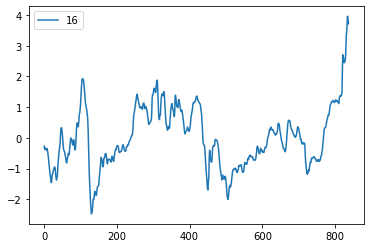

In [26]:
tmp = pd.DataFrame(normalized_data)

tmp.plot(y=normalized_data.shape[1]-1)

# 5. Generate Training and Validation Datasets

In [27]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, 
                                             shape=(n_row, window_size, config["model"]["input_size"]), 
                                             strides=(x.strides[0], x.strides[0], x.strides[0]))
    return output[:-1], output[-1]


def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:,-1] # last column = targets
    return output

In [28]:
data_x, data_x_unseen = prepare_data_x(normalized_data, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data, window_size=config["data"]["window_size"])

# split dataset

split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

print("Train data shape", data_x_train.shape, data_y_train.shape)
print("Validation data shape", data_x_val.shape, data_y_val.shape)

Train data shape (662, 10, 17) (662,)
Validation data shape (166, 10, 17) (166,)


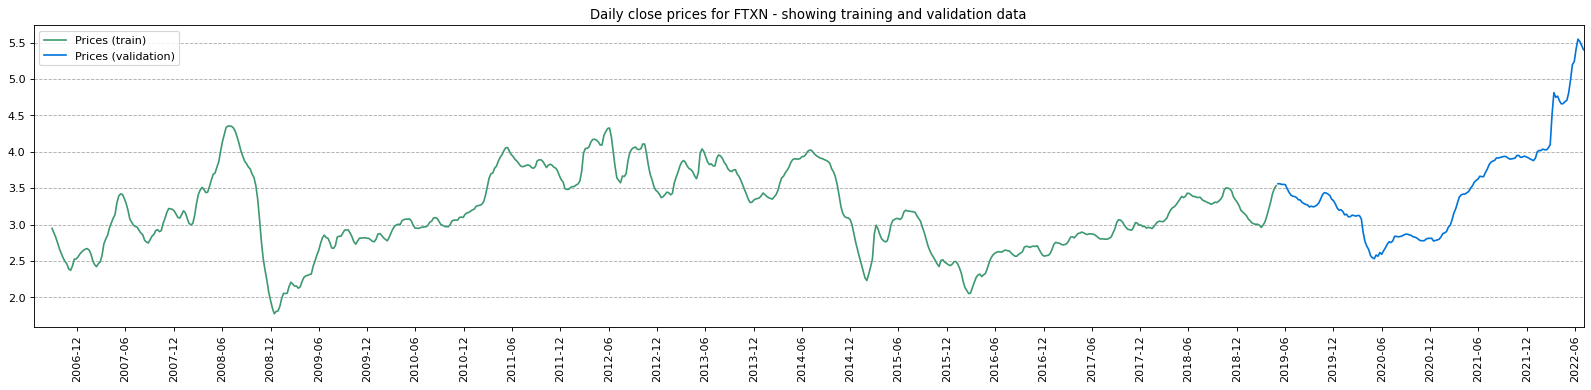

In [29]:
# prepare data for plotting

to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)

to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform_y(data_y_train)
to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform_y(data_y_val)

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

## plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
# xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
# x = np.arange(0,len(xticks))
# plt.xticks(x, xticks, rotation='vertical')

# Format the x axis
locator = mdate.MonthLocator(interval=config["plots"]["xticks_interval"])
fmt = mdate.DateFormatter('%Y-%m')
X = plt.gca().xaxis
X.set_major_locator(locator) # error
# Specify formatter
X.set_major_formatter(fmt)
plt.xticks(rotation='vertical')
plt.xlim([data_date[0], data_date[-1]])

plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

In [30]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        # x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [31]:
dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

Train data shape (662, 10, 17) (662,)
Validation data shape (166, 10, 17) (166,)


# 6. Build Models

## 6a. Time Series Model (Neural Prophet)

### Train and Test

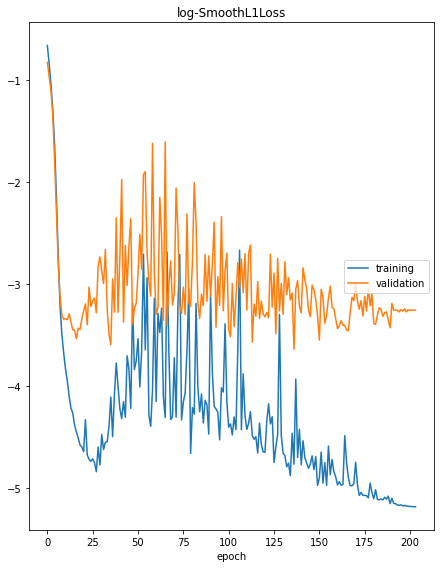

log-SmoothL1Loss
	training         	 (min:   -5.180, max:   -0.664, cur:   -5.180)
	validation       	 (min:   -3.637, max:   -0.830, cur:   -3.255)


In [32]:
data = seattle_gas_prices
df = data['data'].set_axis(['ds', 'y'], axis=1, inplace=False)

# https://rdrr.io/github/AlbertoAlmuinha/neuralprophet/man/neural_prophet.html
params = {
    # "seasonality_mode": "additive", 
    # "learning_rate": 0.1,
    # "n_changepoints": 40, # 48
    # "changepoints_range": 0.95, 
    # "trend_reg": 1,
    # "num_hidden_layers": 2,
    # "d_hidden": 64,
    # "yearly_seasonality": True, # True
    # "weekly_seasonality": False,
    # "daily_seasonality": False,
    # "loss_func": 'MSE',
    # "n_lags": 12,
    # "user_changepoints", 
}

model = NeuralProphet(**params)

df_train, df_test = model.split_df(df=df, freq="W", valid_p=0.15)

metrics =  model.fit(df_train, freq="W", validation_df=df_test, progress="plot")

In [33]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
203,0.005627,0.196749,0.259171,0.0,0.038567,0.582971,0.704324


INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.039  0.583  0.704


   SmoothL1Loss       MAE      RMSE
0      0.038567  0.582971  0.704324


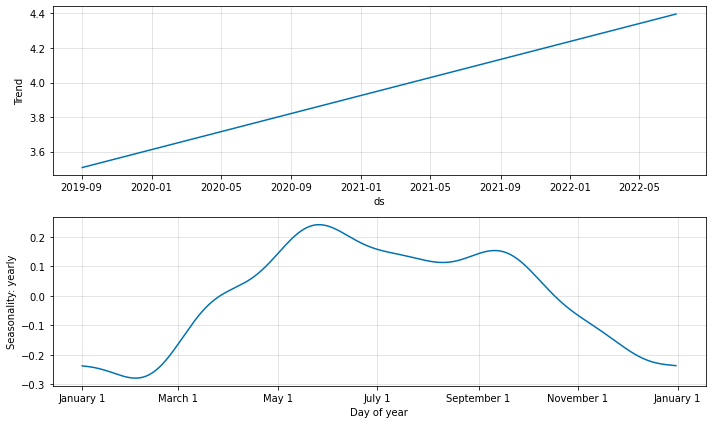

In [34]:
test_pred = model.predict(df_test)
test_components = model.plot_components(test_pred)

test_metrics = model.test(df_test)
print(test_metrics)

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 7))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=False)
model.plot(model.predict(df), ax=ax1)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Seattle Gas Price', fontsize=14)
ax1.set_title("Seattle Gas Price Predictions (Train + Test)", fontsize=24, fontweight="bold")
ax1.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

# fig, ax = plt.subplots(figsize=(10, 7))
model.plot(test_pred, xlabel='Date', ylabel='Seattle Gas Price', ax=ax2)
ax2.set_xlabel('Date', fontsize=14)
ax2.set_ylabel('Seattle Gas Price', fontsize=14)
ax2.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


### Predict into the Future

In [ ]:
model2 = NeuralProphet(**params)
metrics_train2 = model2.fit(df=df, freq="W", progress="plot")

In [ ]:
# fig = model.plot(model2.predict(df))
fig, ax = plt.subplots(figsize=(15, 7))
model.plot(model.predict(df), ax=ax)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Seattle Gas Price', fontsize=14)
ax.set_title("Seattle Gas Price Predictions \n (with model re-trained on all available data)", fontsize=24, fontweight="bold")
ax.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

In [ ]:
future = model2.make_future_dataframe(df, periods=12, n_historic_predictions=96)
forecast = model2.predict(future)

In [ ]:
# fig = model2.plot(forecast)

fig, ax = plt.subplots(figsize=(15, 7))
model.plot(forecast, ax=ax)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Seattle Gas Price', fontsize=14)
ax.set_title("Seattle Gas Price Forecast", fontsize=24, fontweight="bold")
ax.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

## 6b. Neural Network (LSTM)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

## 6c. Attentioned-Based Neural Network (DA-RNN)

In [ ]:
class InputAttentionEncoder(nn.Module):
    def __init__(self, N, M, T, device, stateful=False):
        """
        :param: N: int
            number of time serieses
        :param: M:
            number of LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.N = N
        self.M = M
        self.T = T
        
        self.encoder_lstm = nn.LSTMCell(input_size=self.N, hidden_size=self.M)
        
        #equation 8 matrices
        
        self.W_e = nn.Linear(2*self.M, self.T)
        self.U_e = nn.Linear(self.T, self.T, bias=False)
        self.v_e = nn.Linear(self.T, 1, bias=False)
    
    def forward(self, inputs):
        encoded_inputs = torch.zeros((inputs.size(0), self.T, self.M)).to(device)
        
        #initiale hidden states
        h_tm1 = torch.zeros((inputs.size(0), self.M)).to(device)
        s_tm1 = torch.zeros((inputs.size(0), self.M)).to(device)
        
        for t in range(self.T):
            #concatenate hidden states
            h_c_concat = torch.cat((h_tm1, s_tm1), dim=1)
            
            #attention weights for each k in N (equation 8)
            x = self.W_e(h_c_concat).unsqueeze_(1).repeat(1, self.N, 1)
            y = self.U_e(inputs.permute(0, 2, 1))
            z = torch.tanh(x + y)
            e_k_t = torch.squeeze(self.v_e(z))
        
            #normalize attention weights (equation 9)
            alpha_k_t = F.softmax(e_k_t, dim=1)
            
            #weight inputs (equation 10)
            weighted_inputs = alpha_k_t * inputs[:, t, :] 
    
            #calculate next hidden states (equation 11)
            h_tm1, s_tm1 = self.encoder_lstm(weighted_inputs, (h_tm1, s_tm1))
            
            encoded_inputs[:, t, :] = h_tm1
        return encoded_inputs
    
class TemporalAttentionDecoder(nn.Module):
    def __init__(self, M, P, T, device, stateful=False):
        """
        :param: M: int
            number of encoder LSTM units
        :param: P:
            number of deocder LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.M = M
        self.P = P
        self.T = T
        self.stateful = stateful
        
        self.decoder_lstm = nn.LSTMCell(input_size=1, hidden_size=self.P)
        
        #equation 12 matrices
        self.W_d = nn.Linear(2*self.P, self.M)
        self.U_d = nn.Linear(self.M, self.M, bias=False)
        self.v_d = nn.Linear(self.M, 1, bias = False)
        
        #equation 15 matrix
        self.w_tilda = nn.Linear(self.M + 1, 1)
        
        #equation 22 matrices
        self.W_y = nn.Linear(self.P + self.M, self.P)
        self.v_y = nn.Linear(self.P, 1)
        
    def forward(self, encoded_inputs, y):
        
        #initializing hidden states
        d_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).to(device)
        s_prime_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).to(device)
        for t in range(self.T):
            #concatenate hidden states
            d_s_prime_concat = torch.cat((d_tm1, s_prime_tm1), dim=1)
            #print(d_s_prime_concat)
            #temporal attention weights (equation 12)
            x1 = self.W_d(d_s_prime_concat).unsqueeze_(1).repeat(1, encoded_inputs.shape[1], 1)
            y1 = self.U_d(encoded_inputs)
            z1 = torch.tanh(x1 + y1)
            l_i_t = self.v_d(z1)
            
            #normalized attention weights (equation 13)
            beta_i_t = F.softmax(l_i_t, dim=1)
            
            #create context vector (equation_14)
            c_t = torch.sum(beta_i_t * encoded_inputs, dim=1)
            
            #concatenate c_t and y_t
            y_c_concat = torch.cat((c_t, y[:, t, :]), dim=1)
            #create y_tilda
            y_tilda_t = self.w_tilda(y_c_concat)
            
            #calculate next hidden states (equation 16)
            d_tm1, s_prime_tm1 = self.decoder_lstm(y_tilda_t, (d_tm1, s_prime_tm1))
        
        #concatenate context vector at step T and hidden state at step T
        d_c_concat = torch.cat((d_tm1, c_t), dim=1)

        #calculate output
        y_Tp1 = self.v_y(self.W_y(d_c_concat))
        return y_Tp1
    
class DARNN(nn.Module):
    def __init__(self, N, M, P, T, device, stateful_encoder=False, stateful_decoder=False):
        """
        :param: N: int
            number of time series
        :param: M: int
            number of encoder LSTM units
        :param: P:
            number of deocder LSTM units
        :param: T:
            number of timesteps
        :param: stateful_encoder & stateful_decoder:
            decides whether to initialize cell state of new time window with 
            values of the last cell state of previous time window or to 
            initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.encoder = InputAttentionEncoder(N, M, T, device, stateful_encoder).to(device)
        self.decoder = TemporalAttentionDecoder(M, P, T, device, stateful_decoder).to(device)
    def forward(self, X_history, y_history):
        out = self.decoder(self.encoder(X_history), y_history)
        return out

## 6d. LSTM Updated

In [ ]:
class LSTM2(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, dropout=0.1):
        super(LSTM2, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        
        # Define activation function
        self.relu = nn.ReLU()

    def forward(self, x, h_0, c_0):
        
        # Propagate input through LSTM
        self.lstm.flatten_parameters()
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        out = self.relu(output[:,-1,:])
        out = self.fc(out) 
        
        return out, hn, cn
    
    def init_hidden_internal(self, batch_size):
        h_0 = Variable(torch.zeros(
            self.num_layers, batch_size, self.hidden_size)).to(device)
        
        c_0 = Variable(torch.zeros(
            self.num_layers, batch_size, self.hidden_size)).to(device)
        return h_0, c_0

# 7. Model Training

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    # lr = scheduler.get_last_lr()[0]

    return epoch_loss

## 7a. LSTM

In [ ]:
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

input_size = data_x_train.shape[2]

model = LSTMModel(input_size=input_size, hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=7)

# initialize the early_stopping object
patience = config["model"]["patience"]
early_stopping = EarlyStopping(patience=patience, verbose=True)

for epoch in range(config["training"]["num_epoch"]):
    loss_train = run_epoch(train_dataloader, is_training=True)
    loss_val = run_epoch(val_dataloader)
    
    # Learning rate scheduler
    scheduler.step(loss_val)
    lr = optimizer.param_groups[0]['lr']
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr))
    
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(loss_val, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

## 7b. DA-RNN

In [ ]:
data = features_targets
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = config['training']['batch_size']
timesteps = config["data"]["window_size"]
n_timeseries = data.shape[1] - 1
batch_size = 16

up_to_train_idx = int(data.shape[0]*0.70)
up_to_val_idx = int(data.shape[0]*0.85)
train_length = up_to_train_idx
val_length = up_to_val_idx - up_to_train_idx
test_length = data.shape[0] - train_length - val_length
target = 'gas price'

print(train_length, val_length, test_length)

In [ ]:
X = np.zeros((len(data), timesteps, data.shape[1]-1))
y = np.zeros((len(data), timesteps, 1))

In [ ]:
for i, name in enumerate(list(data.columns[:-1])):
    for j in range(timesteps):
        X[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

In [ ]:
for j in range(timesteps):
    y[:, j, 0] = data[target].shift(timesteps - j - 1).fillna(method="bfill")

In [ ]:
prediction_horizon = 1
target = data[target].shift(-prediction_horizon).fillna(method="ffill").values

In [ ]:
X = X[timesteps:]
y = y[timesteps:]
target = target[timesteps:]

In [ ]:
X_train = X[:train_length]
y_his_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_his_val = y[train_length:train_length+val_length]
X_test = X[-val_length:]
y_his_test = y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

In [ ]:
X_train_max = X_train.max(axis=0)
X_train_min = X_train.min(axis=0)
y_his_train_max = y_his_train.max(axis=0)
y_his_train_min = y_his_train.min(axis=0)
target_train_max = target_train.max(axis=0)
target_train_min = target_train.min(axis=0)

In [ ]:
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_val = (X_val - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

y_his_train = (y_his_train - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_val = (y_his_val - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_test = (y_his_test - y_his_train_min) / (y_his_train_max - y_his_train_min)

target_train = (target_train - target_train_min) / (target_train_max - target_train_min)
target_val = (target_val - target_train_min) / (target_train_max - target_train_min)
target_test = (target_test - target_train_min) / (target_train_max - target_train_min)

In [ ]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_his_train_t = torch.Tensor(y_his_train)
y_his_val_t = torch.Tensor(y_his_val)
y_his_test_t = torch.Tensor(y_his_test)
target_train_t = torch.Tensor(target_train)
target_val_t = torch.Tensor(target_val)
target_test_t = torch.Tensor(target_test)

In [ ]:
data_train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=batch_size)
data_val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=batch_size)
data_test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=batch_size)

In [ ]:
darnn = DARNN(N=X_train.shape[2], M=64, P=16, T=X_train.shape[1], device=device).to(device) # 1) M=64, N=16; 2) M=32, N=32
opt = torch.optim.Adam(darnn.parameters(), lr=0.01)
# epoch_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, patience=25)
epoch_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, patience=15)

In [ ]:
epochs = 1000
loss = nn.MSELoss()

# initialize the early_stopping object
patience = config["model"]["patience"]
early_stopping = EarlyStopping(patience=50, verbose=True, path='darnn.pt') 

for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y_h, batch_y in data_train_loader :
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_y_h = batch_y_h.to(device)
        opt.zero_grad()
        y_pred = darnn(batch_x, batch_y_h)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in data_val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_y_h = batch_y_h.to(device)
            output = darnn(batch_x, batch_y_h)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    # Learning rate scheduler
    epoch_scheduler.step(mse_val/len(X_val_t))
    lr = opt.param_groups[0]['lr']
    
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(mse_val/len(X_val_t), darnn)

    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, 
          "val: ", (mse_val/len(X_val_t))**0.5, 
          "LR: ", lr
         )
    if(i % 10 == 0):
        preds = preds*(target_train_max - target_train_min) + target_train_min
        true = true*(target_train_max - target_train_min) + target_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [ ]:
darnn.load_state_dict(torch.load("darnn.pt"))

In [ ]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y_h, batch_y in data_test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_y_h = batch_y_h.to(device)
        output = darnn(batch_x, batch_y_h)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(torch.squeeze(output), batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

In [ ]:
preds = preds*(target_train_max - target_train_min) + target_train_min
true = true*(target_train_max - target_train_min) + target_train_min

mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()

## 7c. LSTM Updated

In [ ]:
lstm = LSTM2(num_classes=1, input_size=n_timeseries, hidden_size=64, num_layers=1, # hidden=64, layers=2
             seq_length=timesteps, dropout=0.2)
opt = torch.optim.Adam(lstm.parameters(), lr=0.01)
epoch_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, patience=15)
# epoch_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, patience=25)

In [ ]:
epochs = 200
loss = nn.MSELoss()

# initialize the early_stopping object
patience = config["model"]["patience"]
early_stopping = EarlyStopping(patience=50, verbose=True, path='lstm.pt') 

for i in range(epochs):
    mse_train = 0

    for batch_x, batch_y_h, batch_y in data_train_loader :
        h, c = lstm.init_hidden_internal(batch_x.shape[0])
        
#         batch_x = batch_x[:,:,-1].to(device)       
#         batch_x = torch.unsqueeze(batch_x, dim=2)
        batch_x = batch_x.to(device)
        
        batch_y = batch_y.to(device)
        batch_y_h = batch_y_h.to(device)
        opt.zero_grad()
        y_pred, h, c = lstm(batch_x, h, c)
        y_pred = y_pred.squeeze(1)        
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in data_val_loader:
            h, c = lstm.init_hidden_internal(batch_x.shape[0])
            
#             batch_x = batch_x[:,:,-1].to(device)
#             batch_x = torch.unsqueeze(batch_x, dim=2)
            batch_x = batch_x.to(device)
            
            batch_y = batch_y.to(device)
            batch_y_h = batch_y_h.to(device)
            output, h, c = lstm(batch_x, h, c)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    # Learning rate scheduler
    epoch_scheduler.step(mse_val/len(X_val_t))
    lr = opt.param_groups[0]['lr']
    
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(mse_val/len(X_val_t), lstm)

    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, 
          "val: ", (mse_val/len(X_val_t))**0.5, 
          "LR: ", lr
         )
    if(i % 10 == 0):
        preds = preds*(target_train_max - target_train_min) + target_train_min
        true = true*(target_train_max - target_train_min) + target_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [ ]:
lstm.load_state_dict(torch.load("lstm.pt"))

In [ ]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y_h, batch_y in data_test_loader:
        h, c = lstm.init_hidden_internal(batch_x.shape[0])
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_y_h = batch_y_h.to(device)
        output, h, c = lstm(batch_x, h, c)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(torch.squeeze(output), batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

preds = preds*(target_train_max - target_train_min) + target_train_min
true = true*(target_train_max - target_train_min) + target_train_min

mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()

# 8. Model Evaluation

In [ ]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

# prepare data for plotting

to_plot_data_y_train_pred = np.zeros(num_data_points)
to_plot_data_y_val_pred = np.zeros(num_data_points)

to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform_y(predicted_train)
to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform_y(predicted_val)

to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_price, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Compare predicted prices to actual prices")
# xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
# x = np.arange(0,len(xticks))
# plt.xticks(x, xticks, rotation='vertical')

# Format the x axis
locator = mdate.MonthLocator(interval=config["plots"]["xticks_interval"])
fmt = mdate.DateFormatter('%Y-%m')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
plt.xticks(rotation='vertical')
plt.xlim([data_date[0], data_date[-1]])

plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

In [ ]:
# prepare data for plotting the zoomed in view of the predicted prices (on validation set) vs. actual prices

to_plot_data_y_val_subset = scaler.inverse_transform_y(data_y_val)
to_plot_predicted_val = scaler.inverse_transform_y(predicted_val)
to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Zoom in to examine predicted price on validation data portion")
# xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
# xs = np.arange(0,len(xticks))
# plt.xticks(xs, xticks, rotation='vertical')

# Format the x axis
locator = mdate.MonthLocator(interval=config["plots"]["xticks_interval"])
fmt = mdate.DateFormatter('%Y-%m')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
plt.xticks(rotation='vertical')

plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

In [ ]:
# Distrubution Suitcases between predicted and actual values

true_value = data_y_train
predicted_value = scaler.inverse_transform_y(predicted_train)

plt.figure(figsize=(7,7))
plt.scatter(true_value, predicted_value, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('Training Prediction Correlation')
plt.show()

In [ ]:
# Distrubution Suitcases between predicted and actual values

true_value = data_y_val
predicted_value = scaler.inverse_transform_y(predicted_val)

plt.figure(figsize=(7,7))
plt.scatter(true_value, predicted_value, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('Validation Prediction Correlation')
plt.show()

# 9. Forecasting Future Stock Prices

In [ ]:
# predict the closing price of the next trading day

model.eval()

# x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0)
prediction = model(x)
prediction = prediction.cpu().detach().numpy()

# prepare plots

plot_range = 10
to_plot_data_y_val = np.zeros(plot_range)
to_plot_data_y_val_pred = np.zeros(plot_range)
to_plot_data_y_test_pred = np.zeros(plot_range)

to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform_y(data_y_val)[-plot_range+1:]
to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform_y(predicted_val)[-plot_range+1:]

to_plot_data_y_test_pred[plot_range-1] = scaler.inverse_transform_y(prediction)

to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

# plot
plot_date_test = data_date[-plot_range+1:]
# for i in range(len(plot_date_test)):
#     plot_date_test[i] = plot_date_test[i].strftime('%m/%d/%Y')
next_week = plot_date_test[-1] + dt.timedelta(days=7)
plot_date_test.append(next_week)

print(len(plot_date_test) ,  len(to_plot_data_y_val))

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next week", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
plt.title("Predicted Seattle gas price of the next week")
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

print("Predicted Seattle gas price of the next week:", round(to_plot_data_y_test_pred[plot_range-1], 2))